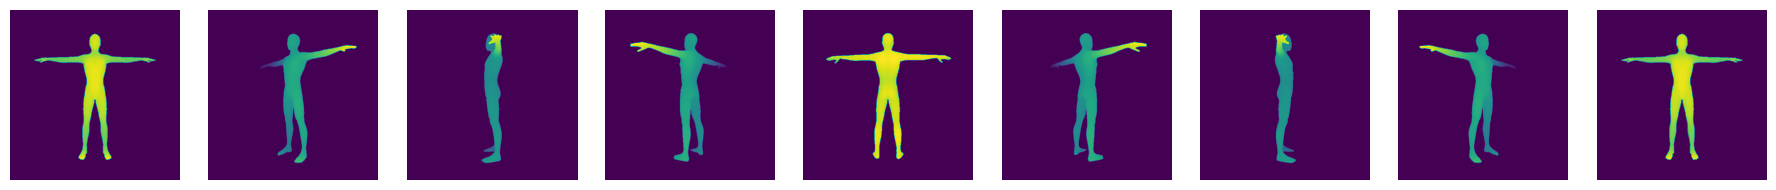

In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map
import torch


torch.set_grad_enabled(False)

animation_tag = 'mixamo-human_rotation:latest'
animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)

verts_uvs, faces_uvs = animation.uv_data()

n_frames = 9
frame_indices = animation.frame_indices(9)
cameras, meshes = animation.load_frames(frame_indices)

depths = render_depth_map(meshes, cameras)
display_ims(depths)

In [2]:
from text3d2video.backprojection import project_visible_texels_to_camera

texture_res = 64

texel_xys = []
texel_uvs = []
for render_cams, render_meshes in zip(cameras, meshes):
    xys, uvs = project_visible_texels_to_camera(
        render_meshes, render_cams, verts_uvs, faces_uvs, texture_res
    )
    texel_xys.append(xys.cpu())
    texel_uvs.append(uvs.cpu())

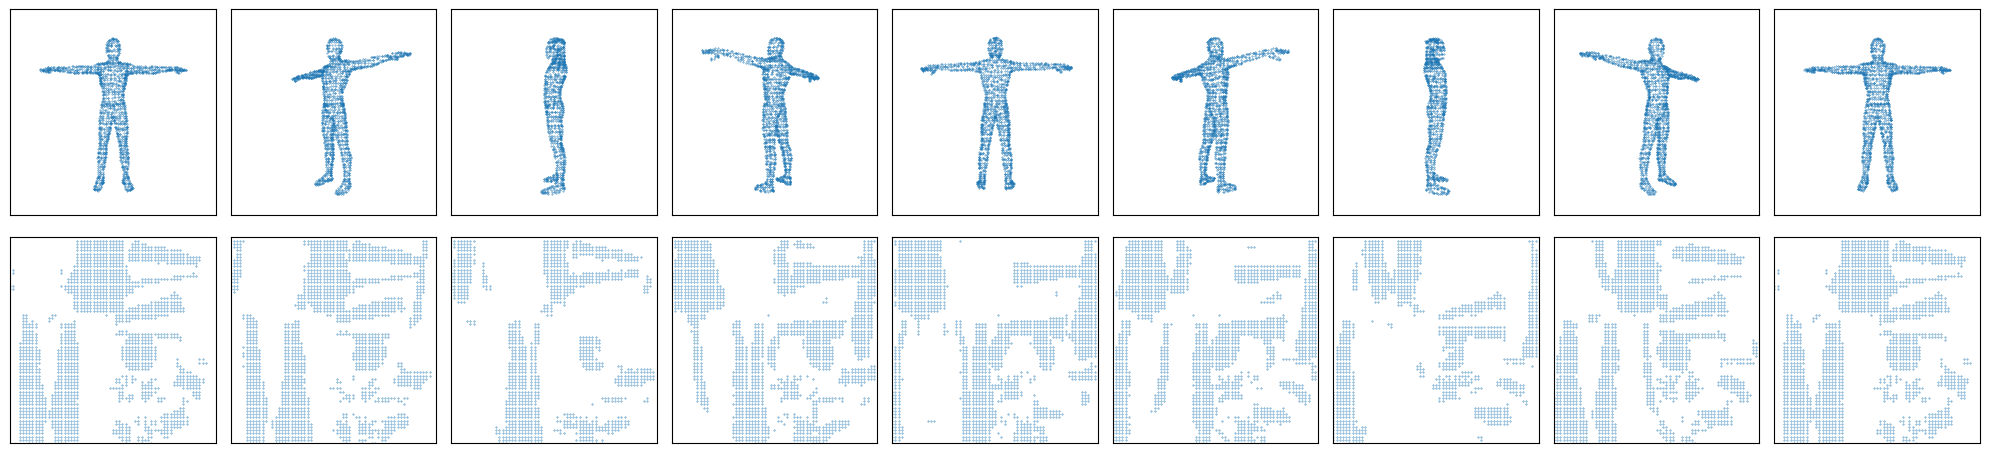

In [3]:
from matplotlib import pyplot as plt

s = 0.1

fig, axs = plt.subplots(2, len(meshes), figsize=(20, 5))
for i, (xy_coords, uv_coords) in enumerate(zip(texel_xys, texel_uvs)):
    ax_cam = axs[0, i]
    ax_uv = axs[1, i]

    ax_cam.scatter(xy_coords[:, 0].cpu(), xy_coords[:, 1].cpu(), s=s)

    ax_uv.scatter(uv_coords[:, 0].cpu(), uv_coords[:, 1].cpu(), s=s)

    ax_uv.set_aspect("equal")
    ax_uv.set_xlim(0, texture_res)
    ax_uv.set_ylim(0, texture_res)

    ax_cam.set_xlim(-1, 1)
    ax_cam.set_ylim(-1, 1)
    ax_cam.set_aspect("equal")

    ax_uv.set_xticks([])
    ax_uv.set_yticks([])
    ax_cam.set_xticks([])
    ax_cam.set_yticks([])

plt.tight_layout()

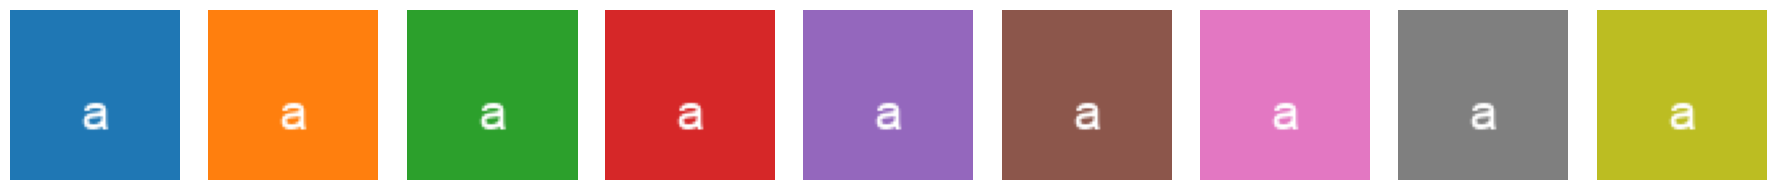

In [4]:
from matplotlib.cm import get_cmap
import torchvision.transforms.functional as TF
from visual_tests.testing_utils import test_img

CAMERA_RES = 64

cmap = get_cmap("tab10")

indices = torch.arange(n_frames)
colors = cmap(indices)

features_cond = [
    test_img(resolution=CAMERA_RES, color=colors[i][0:3], txt="a")
    for i in range(n_frames)
]
feature_maps = torch.stack([TF.to_tensor(img) for img in features_cond])

display_ims(features_cond)

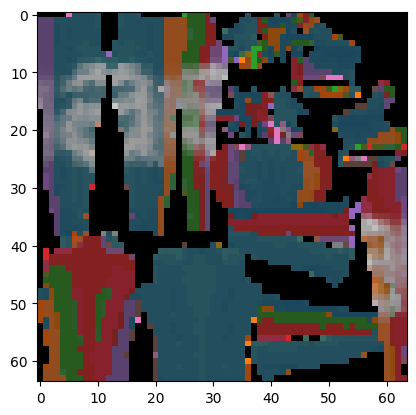

In [27]:
# frame_xy_coords
# frame_uv_coords

from text3d2video.backprojection import gr_aggregate_views_uv_texture

uv_map = gr_aggregate_views_uv_texture(
    feature_maps,
    texture_res,
    texel_xys,
    texel_uvs,
)

plt.imshow(uv_map.cpu())


In [212]:
from pytorch3d.renderer import TexturesUV, TexturesVertex


# uv_map = torch.randn(texture_res, texture_res, 3)


texture = TexturesUV(
    uv_map.cuda().unsqueeze(0), faces_uvs.unsqueeze(0), verts_uvs.unsqueeze(0)
)

vert_features = torch.rand(meshes.num_verts_per_mesh()[0], 3)
texture_vert = TexturesVertex(
    vert_features.cuda().unsqueeze(0)
)

In [213]:
from text3d2video.backprojection import (
    make_repeated_uv_texture,
    make_repeated_vert_texture,
)


torch.cuda.empty_cache()
render_texture = make_repeated_uv_texture(uv_map.cuda(), faces_uvs, verts_uvs, 1)

print(torch.cuda.memory_allocated())

render_texture = make_repeated_uv_texture(uv_map.cuda(), faces_uvs, verts_uvs, 10)

print(torch.cuda.memory_allocated())

256899072
256899072


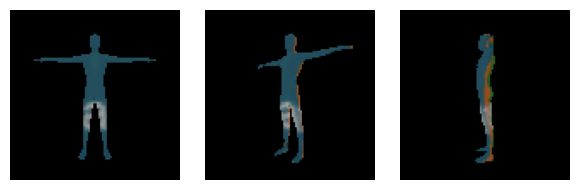

In [218]:
from pytorch3d.renderer import RasterizationSettings, MeshRasterizer

from text3d2video.backprojection import (
    make_repeated_uv_texture,
)
from text3d2video.rendering import TextureShader

indices = torch.Tensor([0, 1, 2]).long()

render_cams = cameras[indices]
render_meshes = meshes[indices]


render_texture = make_repeated_vert_texture(vert_features.cuda(), len(render_meshes))

render_texture = make_repeated_uv_texture(
    uv_map.cuda(), faces_uvs, verts_uvs, len(render_meshes)
)

resolution = 100

raster_settings = RasterizationSettings(
    image_size=resolution, faces_per_pixel=1, bin_size=None
)
rasterizer = MeshRasterizer(cameras=render_cams, raster_settings=raster_settings)
fragments = rasterizer(render_meshes, cameras=render_cams)

shader = TextureShader("cuda")
render_meshes.textures = render_texture
renders = shader(fragments, render_meshes)

display_ims([TF.to_pil_image(r) for r in renders])

In [67]:
from text3d2video.rendering import make_mesh_rasterizer

render_meshes = meshes
render_cams = cameras

rasterizer = make_mesh_rasterizer()
fragments = rasterizer(render_meshes, cameras=render_cams)

render_texture = texture_vert
texture_extended = render_texture.extend(len(render_cams))

rasterize_and_render_texture(texture)

# renders = render_textures(texture_extended, fragments)

# display_ims([TF.to_pil_image(r) for r in renders])

ValueError: Faces can only have three vertices; got 129978

# Aggregation/Rendering for Dict

In [8]:
layers = ["a", "b", "c"]
resolutions = [64, 32, 16]
dtype = torch.float16

layer_resolutions = {layer: resolution for layer, resolution in zip(layers, resolutions)}

def make_features_dict(layers, resolutions, n_frames, text_color='white'):
    return {
        layer: torch.stack(
            [
                test_img(
                    resolution=resolutions[i],
                    color=colors[frame_i][0:3],
                    txt=layers[i],
                    textcolor=text_color,
                    return_type="pt",
                ).to(dtype)
                for frame_i in range(n_frames)
            ]
        )
        for i, layer in enumerate(layers)
    }


features_cond = make_features_dict(layers, resolutions, n_frames)
features_uncond = make_features_dict(layers, resolutions, n_frames, text_color='black')

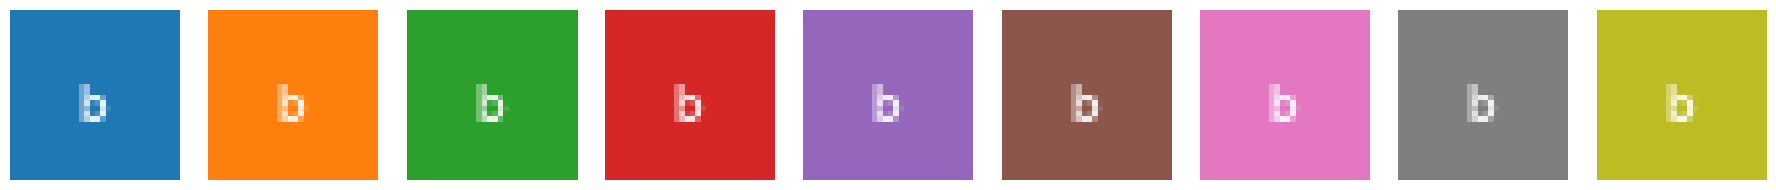

In [9]:
display_ims([TF.to_pil_image(i) for i in features_cond["b"]])

In [10]:
from torch import Tensor
from text3d2video.backprojection import aggregate_views_uv_texture
from text3d2video.util import map_dict

def aggregate(layer: str, features: Tensor):
    uv_map = aggregate_views_uv_texture(features, texture_res, texel_xys, texel_uvs)
    return TexturesUV(
        uv_map.unsqueeze(0).cuda().to(torch.float32),
        faces_uvs.unsqueeze(0),
        verts_uvs.unsqueeze(0),
    )

aggregated_cond = map_dict(features_cond, aggregate)
aggregated_uncond = map_dict(features_uncond, aggregate)

Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size 

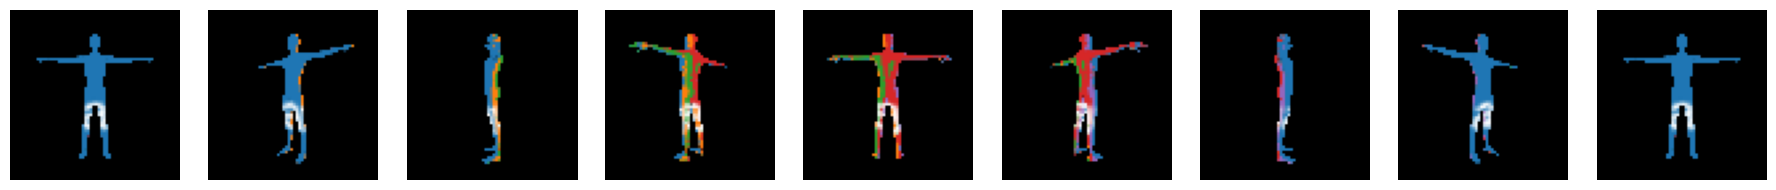

In [11]:
from text3d2video.backprojection import rasterize_and_render_texture

def render(layer, texture: TexturesUV):
    resolution = layer_resolutions[layer]

    return rasterize_and_render_texture(texture, meshes, cameras, resolution)

rendered_cond = map_dict(aggregated_cond, render)
rendered_uncond = map_dict(aggregated_uncond, render)

display_ims([TF.to_pil_image(i) for i in rendered_cond["a"]])